## Retirieveing Data from Census API
This notebook walks through the steps necessary to access Census data through Census API. Currently this notebook only works for census tracts and block groups within NYC. Please open the notebook in Colab to be able to use widgets.

Steps:
* Setup
* Import Geometry
* Retrieve information
* Format tables
* Merge data with shapefiles for mapping. 
* Visualize the information

Please get your API key from Census.gov, by [registering here](https://api.census.gov/data/key_signup.html).


In [ ]:
#@title ### Setup
#@markdown Install necessary dependencies
!pip install geopandas
!pip install seaborn 
!pip install plotly

import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

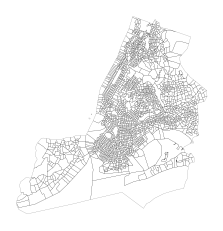

In [2]:
#@title ### Enter Parameters
#@markdown Define Geometry Resolution, Table/Group Name, Product and Year

Table_name = "S1701" #@param ["B19013", "S1701", "S2201"] {allow-input: true}
Product = "acs5" #@param[ "acs5", "acs1" ]
Year = 2018 #@param[2019,2018,2017,2016,2015,2014,2013,2012,2011,2010]
api_key = '155e59c93c8216ac7e2a18584db8417bf7279f7f' #@param
Analysis_Geometry = "Census Tract"  #@param ['Census Tract', 'Block Group' ]

if Analysis_Geometry == 'Census Tract':
  Analysis_Geometry = 'tract'
elif Analysis_Geometry == 'Block Group':
  Analysis_Geometry = 'block%20group'

if Analysis_Geometry == 'tract':
  gdf = gpd.read_file( r'https://raw.githubusercontent.com/PrattSAVI/ACS/master/data/2018_NYC_TRACT.geojson')
if Analysis_Geometry == 'block%20group':
  gdf = gpd.read_file( r'https://raw.githubusercontent.com/PrattSAVI/ACS/master/data/2018_NYC_BG.geojson')

gdf.plot(
    facecolor="none",
    edgecolor="black",
    lw = 0.1,
)
plt.tick_params(left=False , bottom = False , labelleft=False, labelbottom=False)
sns.despine( left = True , bottom = True)
plt.show()

In [4]:
#@title ### Retrieve Data using Census API
#@markdown Census API documenation can be found [here](https://www.census.gov/data/developers/data-sets.html).
bg = pd.DataFrame() #Empty DF to store all info

def get_path( table , geo , county , api_key ): #Decide which path to use for table or group
  if "S" in table:
    path = r'https://api.census.gov/data/2018/acs/acs5/subject?get=NAME,group(' + table + ')&for=' + geo + ':*&in=state:36%20county:' + str(county) + '&key=' + api_key
  if "B" in table:
    path = r'https://api.census.gov/data/2018/acs/acs5?get=NAME,group(' + table + ')&for=' + geo + ':*&in=state:36%20county:' + str(county) + '&key=' + api_key
  return path

for i in gdf['COUNTYFP'].unique(): #Retrieve Block Group info for each County
  path = get_path(Table_name , Analysis_Geometry , i , api_key )
  print ('API URL: ' , path)
  df = pd.read_json( path )
  df.columns = df.loc[0] #First row to column names
  df = df.iloc[1:] #Delete first row

  bg = bg.append( df )

bg.sample(3)

API URL:  https://api.census.gov/data/2018/acs/acs5/subject?get=NAME,group(S1701)&for=tract:*&in=state:36%20county:081&key=155e59c93c8216ac7e2a18584db8417bf7279f7f
API URL:  https://api.census.gov/data/2018/acs/acs5/subject?get=NAME,group(S1701)&for=tract:*&in=state:36%20county:085&key=155e59c93c8216ac7e2a18584db8417bf7279f7f
API URL:  https://api.census.gov/data/2018/acs/acs5/subject?get=NAME,group(S1701)&for=tract:*&in=state:36%20county:047&key=155e59c93c8216ac7e2a18584db8417bf7279f7f
API URL:  https://api.census.gov/data/2018/acs/acs5/subject?get=NAME,group(S1701)&for=tract:*&in=state:36%20county:005&key=155e59c93c8216ac7e2a18584db8417bf7279f7f
API URL:  https://api.census.gov/data/2018/acs/acs5/subject?get=NAME,group(S1701)&for=tract:*&in=state:36%20county:061&key=155e59c93c8216ac7e2a18584db8417bf7279f7f


,NAME,GEO_ID,S1701_C01_001E,S1701_C01_001M,S1701_C02_001E,S1701_C02_001M,S1701_C03_001E,S1701_C03_001M,S1701_C01_002E,S1701_C01_002M,S1701_C02_002E,S1701_C02_002M,S1701_C03_002E,S1701_C03_002M,S1701_C01_003E,S1701_C01_003M,S1701_C02_003E,S1701_C02_003M,S1701_C03_003E,S1701_C03_003M,S1701_C01_004E,S1701_C01_004M,S1701_C02_004E,S1701_C02_004M,S1701_C03_004E,S1701_C03_004M,S1701_C01_005E,S1701_C01_005M,S1701_C02_005E,S1701_C02_005M,S1701_C03_005E,S1701_C03_005M,S1701_C01_006E,S1701_C01_006M,S1701_C02_006E,S1701_C02_006M,S1701_C03_006E,S1701_C03_006M,S1701_C01_007E,S1701_C01_007M,...,S1701_C03_055MA,S1701_C01_056EA,S1701_C01_056MA,S1701_C02_056EA,S1701_C02_056MA,S1701_C03_056MA,S1701_C03_056EA,S1701_C01_057EA,S1701_C01_057MA,S1701_C02_057EA,S1701_C02_057MA,S1701_C03_057EA,S1701_C03_057MA,S1701_C01_058MA,S1701_C01_058EA,S1701_C02_058EA,S1701_C02_058MA,S1701_C03_058EA,S1701_C03_058MA,S1701_C01_059MA,S1701_C01_059EA,S1701_C02_059EA,S1701_C02_059MA,S1701_C03_059EA,S1701_C03_059MA,S1701_C01_060MA,S1701_C01_060EA,S1701_C02_060EA,S1701_C02_060MA,S1701_C03_060EA,S1701_C03_060MA,S1701_C01_061MA,S1701_C01_061EA,S1701_C02_061EA,S1701_C02_061MA,S1701_C03_061MA,S1701_C03_061EA,state,county,tract
287,"Census Tract 175, Bronx County, New York",1400000US36005017500,7119,602,3055,687,42.9,8.8,1827,462,1010,396,55.3,15.7,440,191,177,143,40.2,26.2,1387,386,833,326,60.1,16.8,1827,462,1010,396,55.3,15.7,4279,495,1616,472,37.8,9.4,1960,385,...,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,(X),(X),(X),(X),None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,36,005,017500
16,"Census Tract 122, Richmond County, New York",1400000US36085012200,3822,312,151,117,4.0,3.1,598,131,0,12,0.0,5.3,104,52,0,12,0.0,26.3,494,117,0,12,0.0,6.4,598,131,0,12,0.0,5.3,2529,245,126,103,5.0,4.0,802,164,...,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,(X),(X),(X),(X),None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,36,085,012200
312,"Census Tract 1139, Queens County, New York",1400000US36081113900,3320,283,331,169,10.0,5.2,583,134,30,50,5.1,8.7,280,123,12,19,4.3,7.5,303,99,18,31,5.9,10.3,583,134,30,50,5.1,8.7,1982,246,154,103,7.8,5.1,711,183,...,None,None,None,None,None,None,None,None,None,None,None,None,None,N,N,(X),(X),(X),(X),None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,36,081,113900


In [6]:
#Remove all values keeping the columns to be converted to numeric

data_cols = bg.columns[ bg.columns.str.contains( Table_name ) ]
for _ in data_cols.tolist():
  bg.loc[ bg[_] ==  '(X)' , _ ] = None
  bg.loc[ bg[_] ==  '*' , _ ] = None
  bg.loc[ bg[_] ==  '**' , _ ] = None
  bg.loc[ bg[_] ==  '***' , _ ] = None
  bg.loc[ bg[_] ==  '-' , _ ] = None
  bg.loc[ bg[_] ==  'N' , _ ] = None
  bg.loc[ bg[_] ==  '250,000+' , _ ] = 250001
  bg.loc[ bg[_] ==  -666666666 , _ ] = None
  bg.loc[ bg[_] ==  -222222222 , _ ] = None
  bg[_] = bg[_].astype( float )

bg.sample(3)

ValueError: ignored

In [ ]:
bg_clean = bg #New df for the cleaned data

#All available Column names
cols = pd.read_json( r'https://api.census.gov/data/2018/acs/acs5/variables.json' )

#Use label column names if available
label = []
for c in bg_clean.columns.tolist():
    temp = cols[ cols.index == c ]
    if len(temp) != 0:
      col_name =  temp['variables'][0]['label'] 
      label.append( col_name )
    else:
      label.append( c )
bg_clean.columns = label 

#Clean data
bg_clean = bg_clean.dropna( how = 'all' , axis = 1) #Remove columns if there is no value  

bg_clean = bg_clean.loc[:,~bg_clean.columns.duplicated()] #Remove duplicate NAME Columns
bg_clean = bg_clean[ bg_clean.columns[ ~bg_clean.columns.str.contains('EA') ] ] #Remove Annotations Columns
bg_clean = bg_clean[ bg_clean.columns[ ~bg_clean.columns.str.contains('MA') ] ] #Remove Annotations Columns

bg_clean.sample( 3 )

,NAME,Geography,Estimate!!Median household income in the past 12 months (in 2018 inflation-adjusted dollars),B19013_001M,state,county,tract
10,"Census Tract 248, Bronx County, New York",1400000US36005024800,58553.0,12077.0,36,005,024800
4,"Census Tract 371, Bronx County, New York",1400000US36005037100,27925.0,8082.0,36,005,037100
148,"Census Tract 74, Bronx County, New York",1400000US36005007400,38490.0,6441.0,36,005,007400


In [ ]:
gdf['GEOID_2'] = '1400000US' + gdf['GEOID']
gdf = gdf.join( bg_clean.set_index('Geography') , on = 'GEOID_2' , rsuffix = '_D' )

gdf.head(3)

,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,GEOID_2,NAME_D,Estimate!!Median household income in the past 12 months (in 2018 inflation-adjusted dollars),B19013_001M,NAME_D,B19013_001MA,B19013_001EA,state,county,tract,NAME_D,Estimate!!Median household income in the past 12 months (in 2018 inflation-adjusted dollars)_D,B19013_001M_D,state_D,county_D,tract_D,NAME_D,Estimate!!Median household income in the past 12 months (in 2018 inflation-adjusted dollars)_D,B19013_001M_D,state_D,county_D,tract_D
0,36,081,046200,36081046200,462,Census Tract 462,G5020,S,249611,0,+40.7098547,-073.7879749,"MULTIPOLYGON (((-73.79203 40.71107, -73.79101 ...",1400000US36081046200,"Census Tract 462, Queens County, New York",53295,9902,"Census Tract 462, Queens County, New York",None,None,36,081,046200,"Census Tract 462, Queens County, New York",53295,9902,36,081,046200,"Census Tract 462, Queens County, New York",53295.0,9902.0,36,081,046200
1,36,081,045000,36081045000,450,Census Tract 450,G5020,S,172164,0,+40.7141840,-073.8047700,"MULTIPOLYGON (((-73.80782 40.71591, -73.80767 ...",1400000US36081045000,"Census Tract 450, Queens County, New York",90568,14835,"Census Tract 450, Queens County, New York",None,None,36,081,045000,"Census Tract 450, Queens County, New York",90568,14835,36,081,045000,"Census Tract 450, Queens County, New York",90568.0,14835.0,36,081,045000
2,36,081,045400,36081045400,454,Census Tract 454,G5020,S,230996,0,+40.7126504,-073.7960120,"MULTIPOLYGON (((-73.79870 40.71066, -73.79792 ...",1400000US36081045400,"Census Tract 454, Queens County, New York",45958,10460,"Census Tract 454, Queens County, New York",None,None,36,081,045400,"Census Tract 454, Queens County, New York",45958,10460,36,081,045400,"Census Tract 454, Queens County, New York",45958.0,10460.0,36,081,045400


In [ ]:


import ipywidgets as widgets
from IPython.display import display

w = widgets.Dropdown(
    options= gdf.columns.tolist(),
    description='Choose Column to Visualize:',
    disabled=False,
)

def on_change(change):#Dropdown on_change event
    if change['type'] == 'change' and change['name'] == 'value':
        mapper( change['new'] , gdf )

w.observe( on_change )

print( "Choose a Column to continue!")
display(w)

import plotly.express as px

def mapper(viz_col , gdf): #Mapping is here
  fig = px.choropleth_mapbox(gdf , geojson=gdf.geometry , locations=gdf.index,
                            color= viz_col,opacity = 0.5,
                            hover_name= viz_col ,
                            center={"lat": 40.71, "lon": -74.00},zoom=9,
                            mapbox_style="carto-positron",
                            color_continuous_scale="BuPu", # Here are more colors: https://plotly.com/python/builtin-colorscales/
                          )

  fig.update_traces( marker = dict( line=dict(width=0) ) )
  #fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
  fig.update_layout(width=800,height=600)
  fig.show()


Choose a Column to continue!


Dropdown(description='Choose Column to Visualize:', options=('STATEFP', 'COUNTYFP', 'TRACTCE', 'GEOID', 'NAME'…

ValueError: ignored

ValueError: ignored

ValueError: ignored